# MNIST Fashion classification with convolutional neural network

Study the Convolutionnal neural network (CNN) tutorial of Keras on the classification of the MNIST Fashion Dataset

Learning goals:
- Understand the model structure
- Evaluate and enhance the model
- Use several kinds of regularizers to improve the generalization (kernel/bias, dropout, dataset augmentation)

To compare with the [Dense (Perceptron) only implementation](../classification/ClassificationMultiMnistFashion.html) ([Notebook](../classification/ClassificationMultiMnistFashion.ipynb))

References:
1. [Introduction to CNNs - Tensorflow/Keras](https://www.tensorflow.org/beta/tutorials/images/intro_to_cnns)
2. [Keras Conv2D and Convolutional layer - PyImageSearch](https://www.pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/)
3. [Image preprocessing - Tensorflow/Keras](https://keras.io/preprocessing/image/)
4. [Keras ImageDataGenerator and Data Augmentation - PyImageSearch](https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/)
5. [Classify butterfly images with deep learning in Keras](https://towardsdatascience.com/classify-butterfly-images-with-deep-learning-in-keras-b3101fe0f98)
6. [Fashion MNIST with Keras and Deep Learning - PyImageSearch](https://www.pyimagesearch.com/2019/02/11/fashion-mnist-with-keras-and-deep-learning/)

In [30]:
# If using Plaidml to use hardware accelerators 
usePlaidMl = False
if usePlaidMl:
    import plaidml.keras
    import os
    plaidml.keras.install_backend()
    os.environ['KERAS_BACKEND'] = 'plaidml.keras.backend'

from tensorflow.keras import models, layers, losses, activations, regularizers
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from tensorflow.keras.datasets import fashion_mnist

print('Keras version:', keras.__version__)

# Patch for macOS + Conda
os.environ['KMP_DUPLICATE_LIB_OK']='True'

Keras version: 2.2.4-tf


## Data

Using the fashion MNIST dataset from https://github.com/zalandoresearch/fashion-mnist
It is made of 70k pictures classified in 10 categories. 
Images are greyscale, 28x28 pixels.

The train/test split is 60/10

In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [5]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

image_width = 28
image_height = 28
image_nchannels = 1
n_classes = len(class_names)

batch_size = 128

In [6]:
train_images.shape

(60000, 28, 28)

Reshaping to get a tensor with the channels, and scaling the 8 bit pixels of the images to float values in [0,1)

In [7]:
train_images = train_images.reshape(60000, image_width, image_height, image_nchannels) / 255.0
test_images = test_images.reshape(10000, image_width, image_height, image_nchannels) / 255.0

## Helpers

In [8]:
def plot_history(hist, with_validation=False):
    """ Plot a classification history as outputted by Keras """
    plt.figure(figsize=(15,4))
    plt.subplot(1,3,1)
    plt.plot(hist.history['loss'])
    if with_validation:
        plt.plot(hist.history['val_loss'])
        plt.legend(('train', 'valid'))
    plt.grid()
    plt.title('Loss')
    plt.subplot(1,3,2)
    plt.plot(hist.history['accuracy'])
    if with_validation:
        plt.plot(hist.history['val_accuracy'])
        plt.legend(('train', 'valid'))
    plt.grid()
    plt.title('Accuracy');

In [9]:
# Keras tuto helpers
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array[i], true_label[i], img[i].reshape(image_width, image_height)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img, cmap=plt.cm.binary)
  
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [10]:
def plot_results(images, labels, predictions, num_rows=5, num_cols=3):
    """ Plot the first X test images, their predicted label, and the true label
        Color correct predictions in blue, incorrect predictions in red"""
    num_images = num_rows*num_cols
    plt.figure(figsize=(2*2*num_cols, 2*num_rows))
    for i in range(num_images):
      plt.subplot(num_rows, 2*num_cols, 2*i+1)
      plot_image(i, predictions, labels, images)
      plt.subplot(num_rows, 2*num_cols, 2*i+2)
      plot_value_array(i, predictions, labels)
    plt.show() 

# 2D Convolutional neural network (CNN)

https://www.tensorflow.org/beta/tutorials/images/intro_to_cnns  

__!! Tensorflow v2.0-beta tutorial__ but it works with TF v1.14, convergence is slower though

In [ ]:
model1 = models.Sequential([
    # Single image channel
    layers.Conv2D(32, (3, 3), activation=keras.activations.relu, 
                        input_shape=(image_width, image_height, image_nchannels)), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation=keras.activations.relu),
    layers.Flatten(),
    layers.Dense(64, activation=keras.activations.relu),
    layers.Dense(10, activation=keras.activations.softmax)
], 'model1')

model1.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model1.summary()

In [11]:
hist1 = model1.fit(train_images, train_labels, 
                   epochs=25, validation_split=0.2, batch_size=batch_size,
                   verbose=1)

Model: "model1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 576)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                36928

KeyboardInterrupt: 

Final train accuracy: 0.972


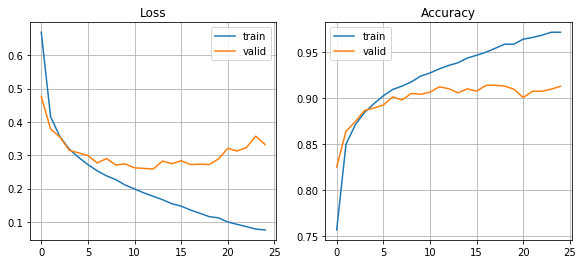

In [15]:
plot_history(hist1, True)
print('Final train accuracy: {:.3f}'.format(hist1.history['accuracy'][-1]))

In [17]:
test_loss1, test_acc1 = model1.evaluate(test_images, test_labels, verbose=0)
print('Test categorical cross-entropy: {:.3f}, accuracy: {:.3f}'.format(test_loss1, test_acc1))

Test categorical cross-entropy: 0.298, accuracy: 0.898


Here again there is a difference between the training and validation or test accuracies.

The result is quite lower compared to the referenced tutorial (claiming 99% test accuracy). Is this due to the use of Tensorflow 1.14 vs. 2.0-beta ?

As on the classical model, there is probably overfitting.

Here is the histogram of the ceofficients of the Dense layer of 64 neurons:

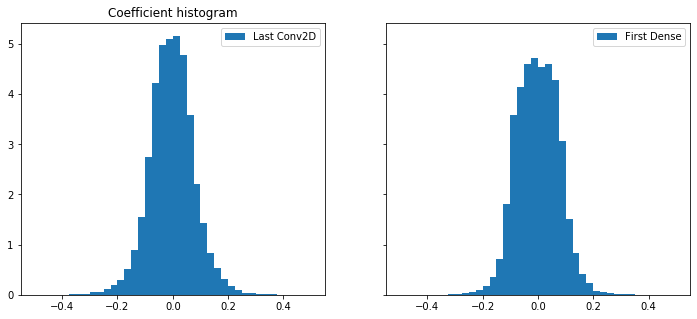

In [27]:
weights1 = model1.get_weights()
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axes[0].hist(weights1[4].reshape(-1), bins=40, range=(-0.5, 0.5), density=True, label='Last Conv2D');
axes[0].set_title('Coefficient histogram');
axes[0].legend()
axes[1].hist(weights1[6].reshape(-1), bins=40, range=(-0.5, 0.5), density=True, label='First Dense');
axes[1].legend();

In [ ]:
predictions1 = model1.predict(test_images[:20])
plot_results(test_images, test_labels, predictions1)

## CNN with regularizer

Let's apply a regularizer on the two largest layers, and decrease the size of the last Conv2D and the 1st Dense layers from 64 to 48.

In [ ]:
model2 = models.Sequential([
    # Single image channel
    layers.Conv2D(32, (3, 3), activation=activations.relu, 
                input_shape=(image_width, image_height, image_nchannels)), 
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation=activations.relu),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(48, (3, 3), activation=keras.activations.relu,
                bias_regularizer=regularizers.l1(0.00001),   # <---
                kernel_regularizer=regularizers.l1(0.00001)), # <---
    layers.Flatten(),
    layers.Dense(48, activation=activations.relu,             # <---
                bias_regularizer=regularizers.l1(0.00001),    # <---
                kernel_regularizer=regularizers.l1(0.00001)), # <---
    layers.Dense(10, activation=activations.softmax)
], 'model2')

model2.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

model2.summary()

In [12]:
hist2 = model2.fit(train_images, train_labels, 
                   epochs=24, validation_split=0.2, 
                   verbose=1)

Model: "model2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 3, 48)          27696     
_________________________________________________________________
flatten_1 (Flatten)          (None, 432)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 48)                20784

Final train accuracy: 0.972


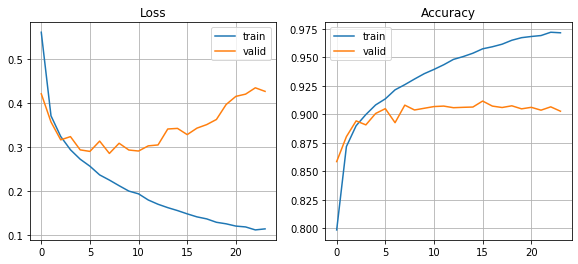

In [14]:
plot_history(hist2, True)
print('Final train accuracy: {:.3f}'.format(hist2.history['accuracy'][-1]))

In [16]:
test_loss2, test_acc2 = model2.evaluate(test_images, test_labels, verbose=0)
print('Test categorical cross-entropy: {:.3f} accuracy: {:.3f}'.format(test_loss2, test_acc2))

Test categorical cross-entropy: 0.452 accuracy: 0.900


Train accuracy is a little lower, test accuracy is the same as with the bigger model.

Coefficients are better spread on the layers with regularizers

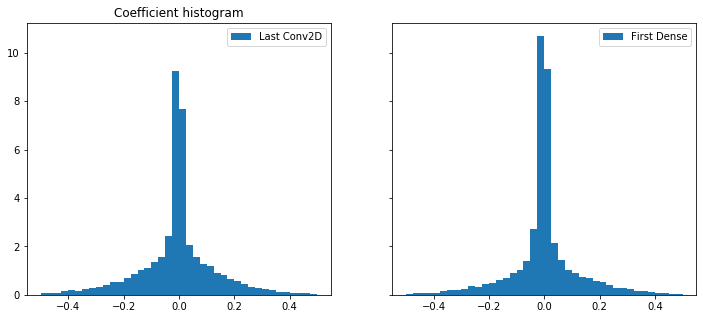

In [26]:
weights2 = model2.get_weights()
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)
axes[0].hist(weights2[4].reshape(-1), bins=40, range=(-0.5, 0.5), density=True, label='Last Conv2D');
axes[0].set_title('Coefficient histogram');
axes[0].legend()
axes[1].hist(weights2[6].reshape(-1), bins=40, range=(-0.5, 0.5), density=True, label='First Dense');
axes[1].legend();

## Using data augmentation

Data augmentation is increasing the size of a training dataset by adding some modified versions of the images, see [4] and [5] for a survey of available technics.

Below, we will use the inline technic through the preprocessor of Keras [3]

In [32]:
batch_size = 128
steps_per_epoch = len(train_images) // batch_size
n_epochs = 32

# Image preprocessor
data_gen3 = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=2,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=False) # All clothes and shoes are the same direction

# For validation data
data_gen3v = keras.preprocessing.image.ImageDataGenerator()

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
#data_gen3.fit(train_images)
#data_gen3v.fit(train_images)

# Clone model to reinit weights
model3 = models.clone_model(model2)
model3.compile(optimizer='adam',
              loss=losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [33]:
# fits the model on batches with real-time data augmentation:
data_gen_flow3 = data_gen3.flow(train_images, train_labels, batch_size=batch_size)
data_gen_flow3v = data_gen3v.flow(train_images, train_labels, batch_size=batch_size)
hist3 = model3.fit_generator(data_gen_flow3, 
                    steps_per_epoch * 0.75, epochs=n_epochs, 
                    validation_data=data_gen_flow3v, validation_steps=steps_per_epoch * 0.25,
                    verbose=1)

AttributeError: 'NumpyArrayIterator' object has no attribute 'shape'

In [ ]:
plot_history(hist3, True)
print('Final train accuracy: {:.3f}'.format(hist3.history['acc'][-1]))

In [ ]:
test_loss3, test_acc3 = model3.evaluate(test_images, test_labels, verbose=0)
print('Test loss: {:.3f}, accuracy: {:.3f}'.format(test_loss3, test_acc3))

In [ ]:
predictions3 = model3.predict(test_images)
plot_results(test_images, test_labels, predictions3)

In [ ]:
print(metrics.classification_report(test_labels, predictions3.argmax(axis=1), target_names=class_names))